# Summary
This project seeks to identify the comparative prevalence of different types of biases in popular comedic movies. Additionally, we test several model archictures to evaluate their ability to classify bias correctly.

# Dependencies & Imports

In [1]:
!pip install datasets
!pip install torch torchvision torchaudio
!pip install -q transformers
!pip install accelerate -U
!pip install contractions
! gdown --id 1__otJTZtqROS61RblDq1OvSbfKcLUVlq
! gdown --id 1IJDS9f2CvPJl6fwoiCIVjLNtgJYXxcq7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.2 MB/s eta 0:00:00
/usr/

## Imports

In [2]:
from datasets import load_dataset
import pandas as pd
import gzip
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np

## Constants


Create dimensions of embeddings and classification categories of bias

In [3]:
EMBEDDING_DIM = 100
LABELS = ["race", "gender", "socioeconomic", "nationality", "religion", "sexual-orientation", "profession", "other", "none"]

Load vocabulary from GloVe embeddings file

In [4]:
# embedding_matrix = np.zeros((len(word_dict), 100))
# idx2vec = np.zeros((len(word_dict), 100))

idx2vec = [[0 for x in range(EMBEDDING_DIM)]]
word2idx = {"<unk>": 0}
with gzip.open('glove.6B.100d.gz','r') as file:
    for i, line in enumerate(file):
        vec = line.decode().split(' ')
        word, vector = vec[0], vec[1:]
        word2idx[word] = i + 1
        vector = [float(num) for num in vector]
        idx2vec.append(vector)

# Preprocessing

Get dataset of unbiased sentences

In [5]:
data_nonbiased = pd.read_excel('train (3).xlsx')
#grab only neutral bias
filtered_data = data_nonbiased[data_nonbiased['Label'] == 'Neutral']
#grab first 3000 rows
neutral_data = filtered_data.head(3000)

Define preprocessing steps:
1. Remove URLs
2. Expand contractions
3. Replace characters without embeddings
4. Strip and lowercase sentences
5. Convert words to embeddings (including unknown words)

In [6]:
#returns processed words
def sentence_list_nuetral(text):
  result = []
  if(pd.isna(text)):
      return
  url_pattern = re.compile(r'https?://\S+|www\.\S+') #remove url
  text = re.sub(url_pattern, '', text)
  contractions = {
      "I'm": "I am",
      "you're": "you are",
      "he's": "he is",
      "she's": "she is",
      "it's": "it is",
      "we're": "we are",
      "they're": "they are",
      "I've": "I have",
      "you've": "you have",
      "he's": "he has",
      "she's": "she has",
      "it's": "it has",
      "we've": "we have",
      "they've": "they have",
      "I'll": "I will",
      "you'll": "you will",
      "he'll": "he will",
      "she'll": "she will",
      "it'll": "it will",
      "we'll": "we will",
      "they'll": "they will",
      "I'd": "I would",
      "you'd": "you would",
      "he'd": "he would",
      "she'd": "she would",
      "it'd": "it would",
      "we'd": "we would",
      "they'd": "they would",
      "isn't": "is not",
      "aren't": "are not",
      "wasn't": "was not",
      "weren't": "were not",
      "haven't": "have not",
      "hasn't": "has not",
      "hadn't": "had not",
      "don't": "do not",
      "doesn't": "does not",
      "didn't": "did not",
      "can't": "cannot",
      "couldn't": "could not",
      "won't": "will not",
      "wouldn't": "would not",
      "shouldn't": "should not",
      "mustn't": "must not",
  }

  for contraction, i in contractions.items():
      text = text.replace(contraction, i)
  # Remove words starting with '@' or containing '*'
  text = re.sub(r'\b\w*[@*]\w*\b', '', text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = text.lower().strip("-'.!?,\"")
  for word in text.split():
    if word:
        word = "<unk>" if word not in word2idx else word
        result.append(word)
  return result

#converts the words to ids
def sentence2idx_list_nuetral(text):
  result = []
  for word in text:
      result.append(word2idx[word])
  return result

text_label_df = neutral_data[['Text', 'Label']]

unbiased_labels = []
unbiased_sentences = []
unbiased_sentences_words= []
for index, row in text_label_df.iterrows():
  unbiased_text = sentence_list_nuetral(row['Text'])
  if unbiased_text is None:
    continue;
  unbiased_sentences_words.append(unbiased_text);
  unbiased_sentences.append(sentence2idx_list_nuetral(unbiased_text))
  unbiased_labels.append(LABELS.index('none'));

Load crows_pair dataset and setnences relevant to study's classifications

In [7]:
crows_pairs_ds = load_dataset("crows_pairs")

# The raw labels of crows_pairs are integers that represent the index of: ["race", "socioeconomic", "gender", "disability", "nationality", "sexual-orientation", "physical-appearance", "religion", "age"]

# These are the conversion label values from each of the raw labels
CROWS_PAIRS_IDX2LABELS = ["race", "socioeconomic", "gender", "other", "nationality", "sexual-orientation", "other", "religion", "other"]

crows_pairs_labels = crows_pairs_ds["test"]["bias_type"]
# Convert the label values from the crows_pairs dataset to the labels that we are using in this project
for i in range(len(crows_pairs_labels)):
  label = CROWS_PAIRS_IDX2LABELS[crows_pairs_labels[i]]
  crows_pairs_labels[i] = LABELS.index(label)


# List of raw strings that represent list of sentences.
crows_pairs_sentences = crows_pairs_ds["test"]["sent_more"]

# Convert each sentence to a list of the word indices.
def sentence2idx_list(sentence):
  result = []
  for raw_word in sentence.split():
    word = raw_word.lower().strip(".!?,\"")
    word = "<unk>" if word not in word2idx else word
    result.append(word2idx[word])
  return result

def sentence_list(sentence):
  result = []
  for raw_word in sentence.split():
    word = raw_word.lower().strip(".!?,\"")
    word = "<unk>" if word not in word2idx else word
    result.append(word)
  return result

crows_pairs_sentences_words=[]
for i in range(len(crows_pairs_sentences)):
  sentence = crows_pairs_sentences[i]
  crows_pairs_sentences[i] = sentence2idx_list(crows_pairs_sentences[i])
  crows_pairs_sentences_words.append(sentence_list(sentence));



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.26k [00:00<?, ?B/s]

crows_pairs.py:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

The repository for crows_pairs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/crows_pairs.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating test split:   0%|          | 0/1508 [00:00<?, ? examples/s]

Load stereoset dataset

In [8]:
stereoset_ds = load_dataset("McGill-NLP/stereoset", "intrasentence")
print(stereoset_ds)

# The raw labels of stereoset are strings that represent labels from the set ["race", "gender", "profession", "religion"]

# These are the conversion label from each of the raw label values
STEREOSET_IDX2LABELS = {
    "race": "race",
    "gender": "gender",
    "profession": "profession",
    "religion": "religion"
}

stereoset_labels_raw = stereoset_ds["validation"]["bias_type"]
# Convert the label values from the stereoset dataset to the labels that we are using in this project
for i in range(len(stereoset_labels_raw)):
  label = STEREOSET_IDX2LABELS[stereoset_labels_raw[i]]
  stereoset_labels_raw[i] = LABELS.index(label)

# The raw sentences contains a dictionary with a list of sentences. Each of these sentences applies to the same label.
stereoset_sentences_raw = stereoset_ds["validation"]["sentences"]

# Label each sentence and convert each sentence to a list of the word indices.
stereoset_labels = []
stereoset_sentences = []
stereoset_sentences_words = []
for i in range(len(stereoset_sentences_raw)):
  for sentence in stereoset_sentences_raw[i]["sentence"]:
    stereoset_sentences.append(sentence2idx_list(sentence))
    stereoset_labels.append(stereoset_labels_raw[i])
    stereoset_sentences_words.append(sentence_list(sentence))

README.md:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/599k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/2106 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['id', 'target', 'bias_type', 'context', 'sentences'],
        num_rows: 2106
    })
})


Unify datasets

In [9]:
sentences = crows_pairs_sentences + stereoset_sentences + unbiased_sentences
sentences_words = crows_pairs_sentences_words + stereoset_sentences_words + unbiased_sentences_words
labels = crows_pairs_labels + stereoset_labels + unbiased_labels

## Training Dataset Analysis

Ensure relatively low percentage of unknown words

In [10]:
total_words = 0
unk_words = 0

for sentence in sentences:
  for word in sentence:
    if word == 0:
      unk_words += 1
    total_words += 1

print(unk_words / total_words)

# relatively low percentage of unkown words

0.032518315018315015


Visualize class imbalance

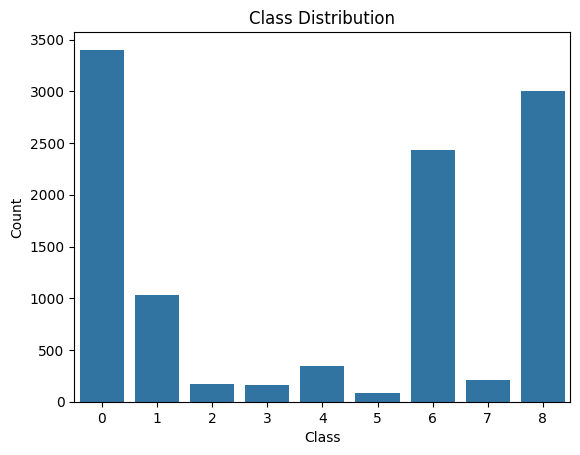

In [11]:
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Load Scripts

In [12]:
# only downloading a few scripts to start

! gdown --id 1mVOAfAJDnjaIA3E0za59Ueudv2YDUzfF
! gdown --id 1hro1zhkVTKHv58vSdnQ_Se4jAP0jDpV3
! gdown --id 1Cr1Ht30dqwLxOTPgdmxgYwJJNWQEmDLp
! gdown --id 11KgvObMyuyj5rEk0SvpslITMNYOaQCfd
! gdown --id 1uVjUrtI1oUCOlr7TEu1aJQNJAvlzNBiX
! gdown --id 1hro1zhkVTKHv58vSdnQ_Se4jAP0jDpV3
! gdown --id 1D8R__d0Fu0cpyLYuP3Jh6RFEehiI5U4W
! gdown --id 1KKAbOoT-95n1ecBd0cIoDf6JNFFTT6VV
! gdown --id 1-8A1nN9xz2aJNhNwwv9zkP3oRVLw_cIh
! gdown --id 1uVjUrtI1oUCOlr7TEu1aJQNJAvlzNBiX
! gdown --id 12R84cBKJfsAtAyjE4MARrdWSd9oUc2g7
! gdown --id 1Cr1Ht30dqwLxOTPgdmxgYwJJNWQEmDLp
! gdown --id 1sIlEP8z9opLqIpS999_L_RoiMPbn4eYc
! gdown --id 1mVOAfAJDnjaIA3E0za59Ueudv2YDUzfF
! gdown --id 1J4S61syRmPS0QEdytqjeBibeuZAp4oWz
! gdown --id 1rIHTjxPyN3MIw1THmD2BDXo2fCpUskn9
! gdown --id 11KgvObMyuyj5rEk0SvpslITMNYOaQCfd
! gdown --id 1diiDscwFcbnArLSSlkk-IFJiuitoDkjN
! gdown --id 1uTll4r-usxb1dOvkPJ5jBr6j8HHoLcFT
! gdown --id 1NrdAp9tY4KeUW_fTWODwmRfdrWzLxLpi
! gdown --id 1QqTiXImQRqdqySmRf5J5HCerkM6b6rjZ
! gdown --id 1Jbi6lGw0N3Q4fLwz5tpE7ekmaAg6cY3k
! gdown --id 1S3Eih5wMz01O0YZi1LWfhpgdHbi4_wcw
! gdown --id 1r8-q6ZJrUqFmP5sF0ldWQcbPasmm13lx
! gdown --id 1KLC4wsd74BpoADKbZ6UIWcGzbDkR-L98
! gdown --id 1n89NRxqu-PEyl0KCJvRVF_fBSyilTcZV


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mVOAfAJDnjaIA3E0za59Ueudv2YDUzfF
To: /content/South Park.txt
100% 254k/254k [00:00<00:00, 75.7MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hro1zhkVTKHv58vSdnQ_Se4jAP0jDpV3
To: /content/Tropic Thunder.txt
100% 176k/176k [00:00<00:00, 54.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https:

Scripts need to be standardized to resemble training data. This involves a few steps that may be lossy, but are necessary within the context of our project's constraints:
1. Perform same preprocessing steps as on training data
2. Split text into smaller blocks, comparable to the size of the training data
3. Map words to embeddings


In [13]:
import contractions

def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

def split_long_blocks(text_blocks, max_block_words=30):
    new_blocks = []
    for block in text_blocks:
        expanded_block = expand_contractions(block)  # Expand contractions
        words = re.findall(r'\b\w+\b', expanded_block.lower())  # Tokenize by words
        current_words = 0
        temp_block = ""
        for word in words:
            if current_words + 1 <= max_block_words:  # Add 1 for the current word
                temp_block += word + " "
                current_words += 1
            else:
                new_blocks.append(temp_block.strip())
                temp_block = word + " "
                current_words = 1

        if temp_block.strip():  # Add remaining block
            new_blocks.append(temp_block.strip())

    return new_blocks

def separate_text_blocks(file_path, max_block_words=30):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    text_blocks = text.split('\n\n')  # Split text into blocks based on blank lines

    # Remove extra whitespace and tabs
    text_blocks = [block.strip() for block in text_blocks]

    # Filter out empty blocks
    text_blocks = [block for block in text_blocks if block]

    # Split long blocks
    text_blocks = split_long_blocks(text_blocks, max_block_words)

    return text_blocks

def index_text_blocks(text_blocks, word2idx):
    indexed_blocks = []
    for block in text_blocks:
        indexed_block = []
        for word in block.split():
            word_idx = word2idx.get(word, word2idx['<unk>'])  # Map to indices or '<unk>'
            indexed_block.append(word_idx)
        indexed_blocks.append(indexed_block)
    return indexed_blocks


# raw_scripts = ['South Park.txt', 'Tropic Thunder.txt', 'Ted.txt', 'Do The Right Thing.txt', 'The Big Sick.txt']
raw_scripts = [
    "Tropic Thunder.txt",
    "The Hangover.txt",
    "The Devil Wears Prada.txt",
    "The Cable Guy.txt",
    "The Big Sick.txt",
    "The Big Lebowski.txt",
    "Ted.txt",
    "Superbad.txt",
    "South Park.txt",
    "Office Space.txt",
    "Jojo Rabbit.txt",
    "Do The Right Thing.txt",
    "Dear White People.txt",
    "Bad Santa.txt",
    "Austin Powers, The Spy Who Shagged Me.txt",
    "Austin Powers, International Man of Mystery.txt",
    "American Pie.txt",
    "Airplane.txt",
    "10 Things I Hate About You Script.txt",
    "17 Again.txt",
    "Ace Ventura, Pet Detective.txt"
]

indexed_scripts = []
raw_script_blocks = []

# Load and preprocess the scripts
for script_file in raw_scripts:
    # Load unembedded text blocks
    unembedded_script = separate_text_blocks(script_file)
    raw_script_blocks.append(unembedded_script)

    # Index the text blocks
    indexed_script = index_text_blocks(unembedded_script, word2idx)
    indexed_scripts.append(indexed_script)

# Now, indexed_scripts contains the indexed representation of each script's text blocks
# raw_script_blocks contains the original text blocks for each script


# Model Training & Results

In this section, we train different models on our sets of biased/unbiased texts. Then, using the trained model, we run the preprocessed film scripts to get the proportional prevalence of bias types among the corpus.

## TFIDF Feature Extraction
Some models will use TF-IDF as opposed to embeddings

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()

input_data = [' '.join(words) for words in sentences_words]
output_data = labels

x_train_words, x_test_words, y_train_words, y_test_words = train_test_split(input_data, output_data, test_size=0.2, random_state=23)


tfidf = vectorizer.fit_transform(input_data)
tfidf_array = tfidf.toarray()

x_train, x_test, y_train, y_test = train_test_split(tfidf_array, output_data, test_size=0.2, random_state=23)


## Scoring & Analysis Functions
Define how models will be scored, prevalence of different biases will be analyzed

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report
def scores(output, predicted):
  accuracy = accuracy_score(output, predicted)
  precision = precision_score(output, predicted, average='weighted')
  recall = recall_score(output, predicted, average='weighted') #recall
  f1 = f1_score(output, predicted, average='weighted') #f1 score
  print("Accuracy: ", accuracy, " Precision: ", precision, " Recall: ", recall, " F1: ", f1)


In [16]:
def script_data(model):
    # Set the style
    sns.set_palette("husl")

    # Initialize counter
    total_counter = Counter()

    # Process data
    for script_name in raw_scripts:
        prediction_counts = Counter()

        with open(f"{script_name}_predictions_and_text_blocks.txt", "r") as file:
            lines = file.readlines()

            for line in lines:
                if line.startswith("Prediction:"):
                    prediction = line.split(":")[1].strip()
                    prediction_counts[prediction] += 1
                    total_counter[prediction] += 1

        print(f"{script_name}: {dict(prediction_counts)}")

    print("\nTotal counts:", dict(total_counter))

    # Remove 'none' category if present
    if 'none' in total_counter:
        del total_counter['none']

    # Prepare data for plotting
    labels = list(total_counter.keys())
    counts = list(total_counter.values())

    # Create figure
    plt.figure(figsize=(12, 8))

    # Create pie chart
    wedges, texts, autotexts = plt.pie(counts,
                                      labels=labels,
                                      autopct='%1.1f%%',
                                      pctdistance=0.85,
                                      wedgeprops={'width': 0.5, 'edgecolor': 'white'},
                                      textprops={'fontsize': 12})

    # Enhance text properties
    plt.setp(autotexts, size=10, weight="bold")
    plt.setp(texts, size=12)

    # Add title with custom formatting
    plt.title(f'Distribution of Predictions - {model}',
              pad=20,
              size=16,
              weight='bold')

    # Add a legend
    plt.legend(wedges, labels,
              title="Categories",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    # Ensure the plot is shown in full without cutting off
    plt.tight_layout()

    return plt.show()


In [17]:
def reportPrint(classification_report_data, model):
  # Parse classification report data
  lines = classification_report_data.strip().split('\n')
  class_labels = [line.split()[0] for line in lines[2:-5]]
  precision = [float(line.split()[1]) for line in lines[2:-5]]
  recall = [float(line.split()[2]) for line in lines[2:-5]]
  f1_score = [float(line.split()[3]) for line in lines[2:-5]]

  label_to_index = {label: index for index, label in enumerate(class_labels)}
  indices = [label_to_index[label] for label in class_labels]
  classes = [LABELS[index] for index in indices]

  # Plot bar chart
  x = np.arange(len(classes))
  width = 0.25

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width, precision, width, label='Precision')
  rects2 = ax.bar(x, recall, width, label='Recall')
  rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

  ax.set_ylabel('Scores')
  ax.set_title('Scores by class ' + model)
  ax.set_xticks(x)
  ax.set_xticklabels(classes, rotation=90)
  ax.legend()

  fig.tight_layout()

  plt.show()

## SVM

### Training

Accuracy:  0.9270207852193996  Precision:  0.9278704443273637  Recall:  0.9270207852193996  F1:  0.9210388986018125
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       644
           1       0.87      0.87      0.87       206
           2       0.91      0.47      0.62        43
           3       0.92      0.29      0.44        38
           4       0.97      0.91      0.94        69
           5       0.82      0.50      0.62        18
           6       0.99      0.99      0.99       501
           7       0.86      0.49      0.62        37
           8       0.87      0.98      0.92       609

    accuracy                           0.93      2165
   macro avg       0.91      0.72      0.78      2165
weighted avg       0.93      0.93      0.92      2165



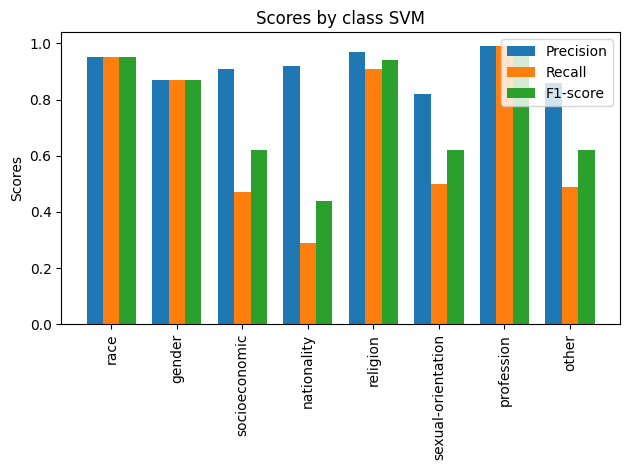

In [18]:
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import numpy as np


svm = LinearSVC(penalty='l1', random_state=42, C=1, max_iter=1000, dual=False)
svm.fit(x_train, y_train)

y_train_pred = svm.predict(x_train)
y_test_pred = svm.predict(x_test)

scores(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)
print(report)
reportPrint(report, "SVM")


### Results

Tropic Thunder.txt: {'race': 98, 'none': 1282, 'socioeconomic': 17, 'other': 34, 'gender': 107, 'religion': 2, 'profession': 29, 'nationality': 5, 'sexual-orientation': 3}
The Hangover.txt: {'none': 1334, 'race': 65, 'sexual-orientation': 8, 'gender': 165, 'other': 26, 'profession': 24, 'nationality': 4, 'socioeconomic': 44}
The Devil Wears Prada.txt: {'gender': 170, 'none': 1457, 'socioeconomic': 40, 'religion': 23, 'race': 59, 'profession': 37, 'other': 234, 'sexual-orientation': 2, 'nationality': 4}
The Cable Guy.txt: {'none': 1482, 'gender': 221, 'race': 63, 'profession': 37, 'other': 21, 'nationality': 5, 'religion': 2, 'socioeconomic': 2}
The Big Sick.txt: {'race': 142, 'none': 1321, 'socioeconomic': 44, 'gender': 177, 'other': 37, 'profession': 30, 'nationality': 14, 'religion': 5, 'sexual-orientation': 4}
The Big Lebowski.txt: {'none': 1545, 'race': 83, 'socioeconomic': 121, 'gender': 148, 'other': 46, 'profession': 6, 'nationality': 16, 'sexual-orientation': 2}
Ted.txt: {'none

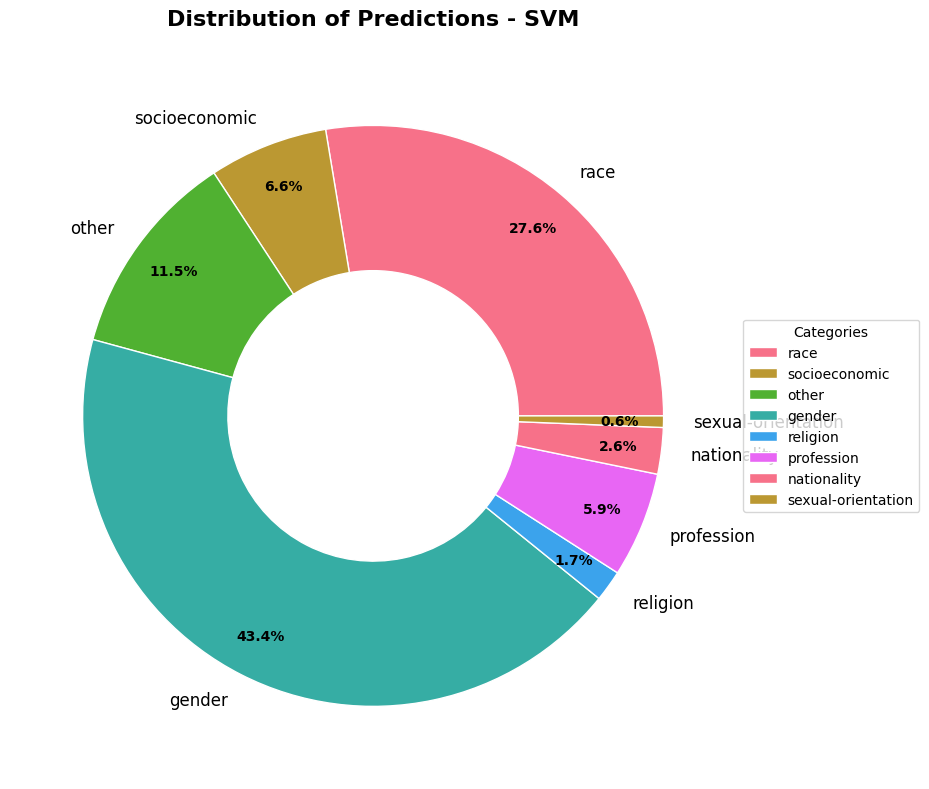

In [19]:
all_predicted_labels = []
all_text_blocks = []

for script_blocks in raw_script_blocks:
  for block in script_blocks:
    tfidf_scripts = vectorizer.transform([block])
    y_block_label = svm.predict(tfidf_scripts)
    all_predicted_labels.append(y_block_label[0])
    all_text_blocks.append(block)


# # Map predicted labels to their corresponding strings
predicted_labels_str = [LABELS[prediction] for prediction in all_predicted_labels]

# # Iterate through each script
for i, script_name in enumerate(raw_scripts):
    script_predictions = predicted_labels_str[i*len(script_blocks):(i+1)*len(script_blocks)]
    script_text_blocks = raw_script_blocks[i]
    # Write predictions and text blocks to the same file
    with open(f"{script_name}_predictions_and_text_blocks.txt", "w") as file:
        for prediction, text_block in zip(script_predictions, script_text_blocks):
            file.write(f"Prediction: {prediction}\n")
            file.write(f"Text Block: {text_block}\n\n")

script_data("SVM")

## Perceptron

### Training

Accuracy:  0.9103926096997691  Precision:  0.9152084728609473  Recall:  0.9103926096997691  F1:  0.9038702084911545
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       644
           1       0.84      0.85      0.85       206
           2       1.00      0.21      0.35        43
           3       0.38      0.47      0.42        38
           4       0.91      0.86      0.88        69
           5       0.47      0.50      0.49        18
           6       0.96      1.00      0.98       501
           7       1.00      0.30      0.46        37
           8       0.91      0.98      0.94       609

    accuracy                           0.91      2165
   macro avg       0.82      0.68      0.70      2165
weighted avg       0.92      0.91      0.90      2165



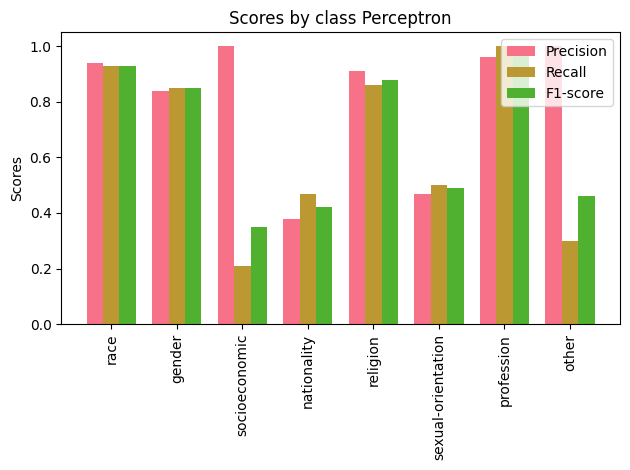

In [20]:
from sklearn.linear_model import Perceptron

per = Perceptron()
per.fit(x_train, y_train)
y_train_pred = per.predict(x_train)
y_test_pred = per.predict(x_test)
scores(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)
print(report)
reportPrint(report, "Perceptron")


### Results

Tropic Thunder.txt: {'none': 10, 'profession': 1, 'gender': 1, 'race': 1, 'socioeconomic': 1}
The Hangover.txt: {'none': 100, 'race': 9, 'profession': 13, 'nationality': 10, 'gender': 12, 'sexual-orientation': 2, 'religion': 1, 'socioeconomic': 1}
The Devil Wears Prada.txt: {'none': 24, 'gender': 6, 'race': 1, 'nationality': 2, 'religion': 1, 'socioeconomic': 1, 'sexual-orientation': 2, 'profession': 1}
The Cable Guy.txt: {'gender': 1, 'none': 5, 'race': 1}
The Big Sick.txt: {'religion': 2, 'gender': 3, 'race': 3, 'none': 7, 'nationality': 1}
The Big Lebowski.txt: {'nationality': 7, 'none': 60, 'race': 2, 'gender': 5, 'other': 5, 'profession': 6, 'religion': 1}
Ted.txt: {'none': 6, 'profession': 1}
Superbad.txt: {'none': 15, 'race': 1, 'sexual-orientation': 1, 'nationality': 1, 'profession': 1}
South Park.txt: {'none': 110, 'nationality': 12, 'profession': 9, 'race': 10, 'gender': 17, 'sexual-orientation': 5, 'religion': 1, 'other': 1}
Office Space.txt: {'none': 9, 'gender': 1}
Jojo Ra

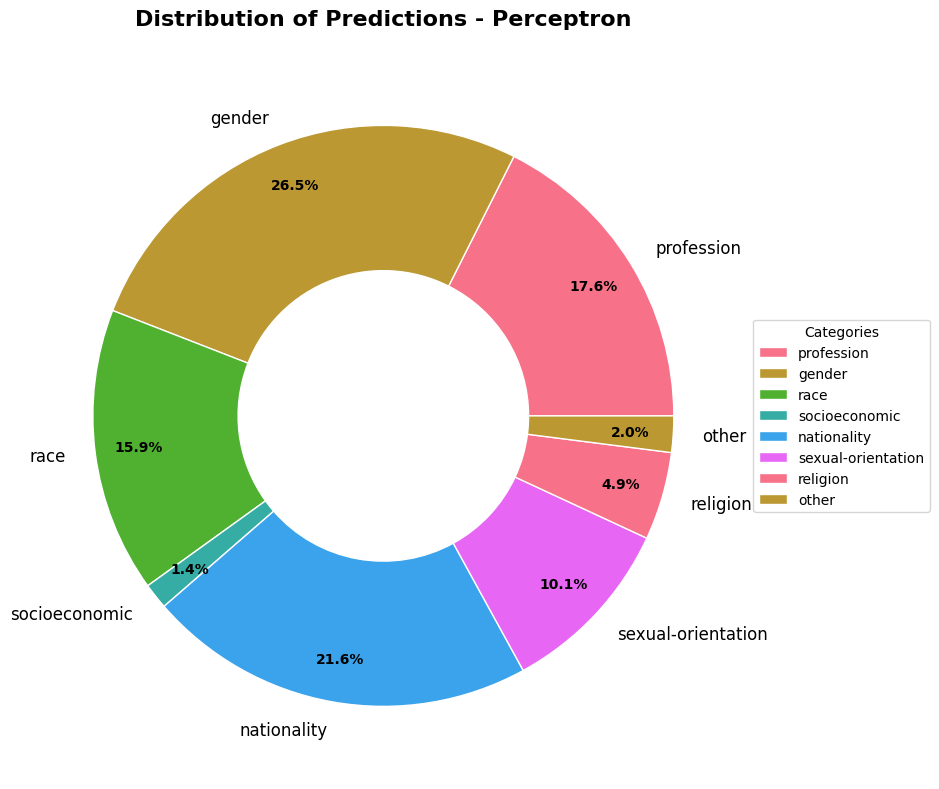

In [21]:
all_predicted_labels = []
all_text_blocks = []

for script_blocks in raw_script_blocks:
    for block in script_blocks:
        tfidf_scripts = vectorizer.transform([block])
        y_block_label = per.predict(tfidf_scripts)
        all_predicted_labels.append(y_block_label[0])
        all_text_blocks.append(block)


# # Map predicted labels to their corresponding strings
predicted_labels_str = [LABELS[prediction] for prediction in all_predicted_labels]

# # Iterate through each script
for i, script_name in enumerate(raw_scripts):
    script_predictions = predicted_labels_str[i*len(script_blocks[i]):(i+1)*len(script_blocks[i])]
    script_text_blocks = raw_script_blocks[i]


    # Write predictions and text blocks to the same file
    with open(f"{script_name}_predictions_and_text_blocks.txt", "w") as file:
        for prediction, text_block in zip(script_predictions, script_text_blocks):
            file.write(f"Prediction: {prediction}\n")
            file.write(f"Text Block: {text_block}\n\n")

script_data("Perceptron")

## BiLSTM

### Training

In [22]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


class LSTMDataset(Dataset):
    def __init__(self, X, y):
        #input
        self.features = X
        #output
        self.labels = y

    def __getitem__(self, index):
      return {
            'words': torch.tensor(self.features[index], dtype=torch.long),
            'label': torch.tensor(self.labels[index], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)


def collate_fn(batch):
    words = [item['words'] for item in batch]
    labels = [item['label'] for item in batch]

    padded_words = pad_sequence(words, batch_first=True, padding_value=0)

    return {
    'words': padded_words,
    'label': torch.tensor(labels, dtype=torch.long)
    }


x_train, x_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=23)

train_data = LSTMDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=14, shuffle=False, collate_fn=collate_fn)

test_data = LSTMDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=14, shuffle=False, collate_fn=collate_fn)


In [23]:
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim , num_classes, dropout, embedding_matrix):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(in_features=2 * hidden_dim, out_features=128)
        self.elu = nn.functional.elu
        self.maxpool1 = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, word_id):
        embedded = self.embedding(word_id)
        output, (h_n, c_n) = self.lstm(embedded)
        output = self.dropout(output)
        output = output.permute(0, 2, 1)
        output = self.maxpool1(output)
        output = output.squeeze(-1)
        output = self.fc1(output)
        output = self.elu(output)
        output = self.classifier(output)
        return output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(vocab_size=len(word2idx), embedding_dim=100, hidden_dim=256, num_classes=9, dropout=0.33, embedding_matrix=idx2vec).to(device)


Epoch [1/4], Accuracy: 81.52%
Epoch [2/4], Accuracy: 89.28%
Epoch [3/4], Accuracy: 90.02%
Epoch [4/4], Accuracy: 91.13%
Accuracy:  0.9113163972286374  Precision:  0.8901208167491752  Recall:  0.9113163972286374  F1:  0.8944951616938255
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       644
           1       0.79      0.87      0.83       206
           2       0.74      0.33      0.45        43
           3       0.00      0.00      0.00        38
           4       0.86      0.94      0.90        69
           5       0.80      0.44      0.57        18
           6       0.98      0.97      0.97       501
           7       0.60      0.08      0.14        37
           8       0.93      0.98      0.96       609

    accuracy                           0.91      2165
   macro avg       0.73      0.62      0.64      2165
weighted avg       0.89      0.91      0.89      2165



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

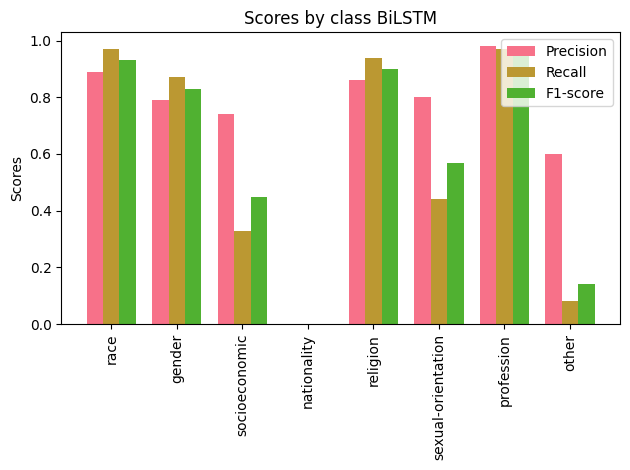

In [24]:
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)



accuracies = []
n_epochs = 4
#train model
for epoch in range(n_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch['words'].to(device))
        loss = loss_fn(output.view(-1,9), batch['label'].to(device))
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total_examples = 0
    true_labels = []
    predicted_labels = []
    #evaluate model
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch['words'].to(device))
            _, predictions = torch.max(outputs, 1)
            true_labels.extend(batch['label'].tolist())
            predicted_labels.extend(predictions.tolist())
            total_examples += batch['label'].size(0)
            correct += (predictions == batch['label'].to(device)).sum().item()

    current_accuracy = correct / total_examples
    accuracies.append(current_accuracy)
    print(f"Epoch [{epoch+1}/{n_epochs}], Accuracy: {100 * current_accuracy:.2f}%")

scores(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
print(report)
reportPrint(report, "BiLSTM")


### Results

Tropic Thunder.txt: {'race': 110, 'none': 1334, 'gender': 95, 'profession': 26, 'religion': 3, 'other': 8, 'sexual-orientation': 1}
The Hangover.txt: {'race': 55, 'none': 1387, 'profession': 24, 'gender': 195, 'other': 3, 'religion': 5, 'sexual-orientation': 1}
The Devil Wears Prada.txt: {'none': 1667, 'gender': 234, 'race': 48, 'religion': 36, 'profession': 36, 'sexual-orientation': 1, 'other': 2, 'socioeconomic': 2}
The Cable Guy.txt: {'none': 1527, 'gender': 178, 'race': 99, 'profession': 20, 'religion': 6, 'sexual-orientation': 1, 'other': 1, 'socioeconomic': 1}
The Big Sick.txt: {'none': 1408, 'profession': 26, 'gender': 207, 'race': 110, 'other': 3, 'religion': 16, 'sexual-orientation': 3, 'socioeconomic': 1}
The Big Lebowski.txt: {'none': 1593, 'race': 52, 'gender': 261, 'religion': 5, 'profession': 30, 'socioeconomic': 16, 'other': 6, 'sexual-orientation': 4}
Ted.txt: {'none': 721, 'race': 99, 'gender': 90, 'other': 2, 'socioeconomic': 1, 'profession': 10, 'religion': 6, 'natio

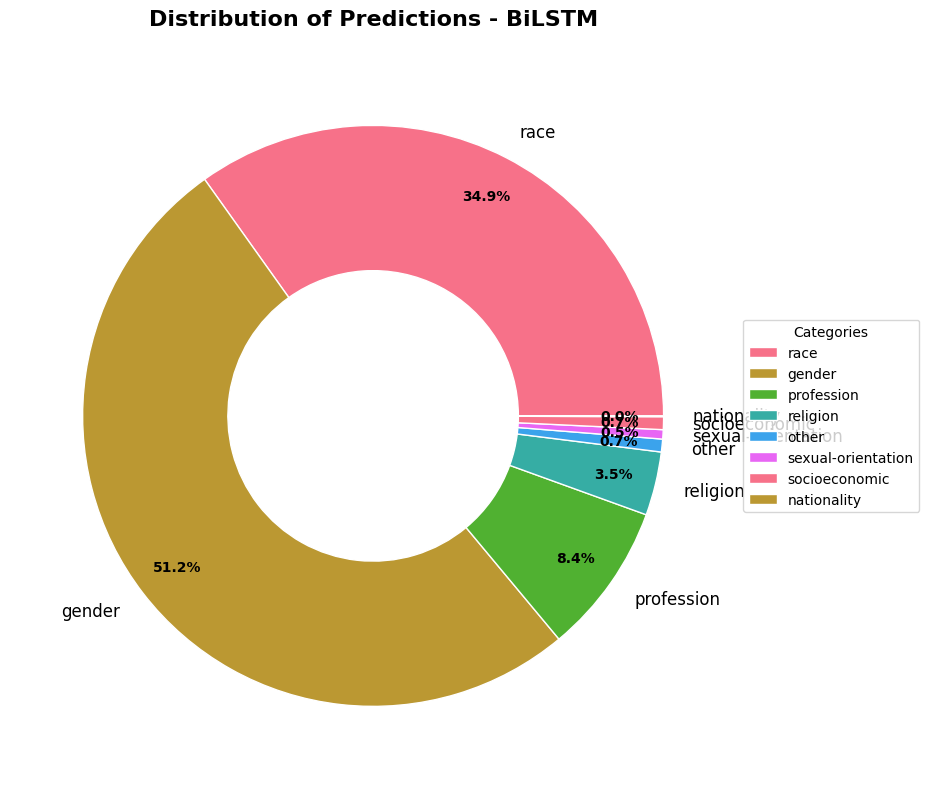

In [25]:
# Initialize lists to store predicted labels and their corresponding text blocks
all_predicted_labels = []
all_text_blocks = []
# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    for script_blocks in indexed_scripts:
        for block in script_blocks:
            # Convert block to tensor and add batch dimension
            block_tensor = torch.tensor(block, dtype=torch.long).unsqueeze(0).to(device)

            # Move block tensor to GPU if available
            block_tensor = block_tensor.to(device)

            # Perform forward pass
            outputs = model(block_tensor)

            # Get predicted labels
            _, predictions = torch.max(outputs, 1)

            # Convert predictions to CPU and append to the list
            all_predicted_labels.append(predictions.cpu().item())

            # Append the text block to the list
            all_text_blocks.append(block)

# Map predicted labels to their corresponding strings
predicted_labels_str = [LABELS[prediction] for prediction in all_predicted_labels]

# Iterate through each script
for i, script_name in enumerate(raw_scripts):
    script_predictions = predicted_labels_str[i*len(script_blocks):(i+1)*len(script_blocks)]
    script_text_blocks = raw_script_blocks[i]

    # Write predictions and text blocks to the same file
    with open(f"{script_name}_predictions_and_text_blocks.txt", "w") as file:
        for prediction, text_block in zip(script_predictions, script_text_blocks):
            file.write(f"Prediction: {prediction}\n")
            file.write(f"Text Block: {text_block}\n\n")


script_data("BiLSTM")


## BeRT

### Training

In [26]:
from transformers import AutoTokenizer, BertTokenizer
import numpy as np


# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_emb = []
test_emb = []

y_train_tensor = torch.tensor(y_train_words)
y_one_hot = torch.zeros(len(y_train_tensor), 9)
y_one_hot.scatter_(1, y_train_tensor.unsqueeze(1), 1)
# print(y_one_hot)
# # flat_labels = [label[0][0] for label in y_train_words]
# # labels_tensor = torch.tensor(y_train_words)
# one_hot_labels_train = torch.zeros(len(labels_tensor), 9)
# print(y_train_words)

# one_hot_labels_train[torch.arange(len(labels_tensor)), labels_tensor] = 1
# flat_labels_train = [label[0][0] for label in y_train_words]
# flat_labels_test = [label[0][0] for label in y_test_words]

for sentence,label in zip(x_train_words, y_one_hot):
    embedding = tokenizer(sentence, padding='max_length', truncation=True, max_length=128)
    embedding["labels"] = label
    train_emb.append(embedding)


# flat_labels = [label[0][0] for label in y_test_words]
# labels_tensor = torch.tensor(y_test_words)
# print(labels_tensor.shape)
# one_hot_labels_test = torch.zeros(len(labels_tensor), 9)
# one_hot_labels_test[torch.arange(len(labels_tensor)), labels_tensor] = 1

y_test_tensor = torch.tensor(y_test_words)
y_one_hot_test = torch.zeros(len(y_test_tensor), 9)
y_one_hot_test.scatter_(1, y_test_tensor.unsqueeze(1), 1)

for sentence,label in zip(x_test_words, y_one_hot_test):
  embedding = tokenizer(sentence, padding='max_length', truncation=True, max_length=128)
  embedding["labels"] = label
  test_emb.append(embedding)

# flat_labels = [label[0][0] for label in y_train_words]
# labels_tensor = torch.tensor(flat_labels)
# one_hot_labels = torch.zeros(len(labels_tensor), 9)
# one_hot_labels[torch.arange(len(labels_tensor)), labels_tensor] = 1

train_data = {"input": train_emb, "labels": y_one_hot}
test_data = {"input": test_emb, "labels": y_one_hot_test}
print(len(train_data["input"]))
print(len(test_data["input"]))

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

8660
2165


In [ ]:
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch.optim as optim
from sklearn.metrics import classification_report


def compute_metrics(pred):
    print(pred)
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # print(labels.shape)
    # print(preds.shape)
    labels_flat = np.argmax(labels, axis=1)
    preds_flat = preds.flatten()
    # print(labels_flat.shape)
    # print(preds_flat.shape)
    precision = precision_score(labels_flat, preds_flat, average='weighted')
    f1 = f1_score(labels_flat, preds_flat, average='weighted')
    accuracy = accuracy_score(labels_flat, preds_flat)
    recall = recall_score(labels_flat, preds_flat, average = 'weighted')
    scores(labels_flat,preds_flat)
    report = classification_report(labels_flat, preds_flat)
    print(report)
    reportPrint(report, "BERT")
    # return as dictionary
    metrics = {'f1': f1,
               'accuracy': accuracy,
               'precision': precision,
               'recall': recall}
    return metrics


tf_train_dataset = Dataset.from_dict(train_data)
tf_test_dataset = Dataset.from_dict(test_data)
tf_train_dataset.set_format("torch")
tf_test_dataset.set_format("torch")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=9)


training_args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    learning_rate=2e-5,
    per_device_train_batch_size=18,
    per_device_eval_batch_size=18,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    evaluation_strategy = "epoch",
    save_strategy = "epoch"
)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tf_train_dataset['input'],
    eval_dataset=tf_test_dataset['input'],
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss


### Results

In [ ]:
# Initialize lists to store predicted labels and their corresponding text blocks
all_predicted_labels = []
all_text_blocks = []
# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    for script_blocks in raw_script_blocks:
        for block in script_blocks:
            # Tokenize the block
            encoded_input = tokenizer(block, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

            # Move input tensors to GPU if available
            input_ids = encoded_input["input_ids"].to(device)
            attention_mask = encoded_input["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # # Convert block to tensor and add batch dimension
            # block_tensor = torch.tensor(block, dtype=torch.long).unsqueeze(0).to(device)

            # # Move block tensor to GPU if available
            # block_tensor = block_tensor.to(device)

            # # Perform forward pass
            # outputs = model(block_tensor)

            logits = outputs.logits

            probabilities = torch.nn.functional.softmax(logits, dim=1)

            # Get predicted labels
            _, predictions = torch.max(probabilities, 1)

            # Convert predictions to CPU and append to the list
            all_predicted_labels.append(predictions.cpu().item())

            # Append the text block to the list
            all_text_blocks.append(block)

# Map predicted labels to their corresponding strings
predicted_labels_str = [LABELS[prediction] for prediction in all_predicted_labels]

# Iterate through each script
for i, script_name in enumerate(raw_scripts):
    script_predictions = predicted_labels_str[i*len(script_blocks):(i+1)*len(script_blocks)]
    script_text_blocks = raw_script_blocks[i]

    # Write predictions and text blocks to the same file
    with open(f"{script_name}_predictions_and_text_blocks.txt", "w") as file:
        for prediction, text_block in zip(script_predictions, script_text_blocks):
            file.write(f"Prediction: {prediction}\n")
            file.write(f"Text Block: {text_block}\n\n")

script_data("BERT")